### Processamento de linguagens naturais de tweets com keras

Sabemos que uo Twitter é uma das maiores redes sociais da atualizade. É por lá que grande parte das pessoas expressa suas opiniões, emoções e reportam problemas em suas vidas. A rede se torna mais interessante quando paramos para analisar os desastres que as pessoas estão reportando em suas contas. A cultura de hashtags e as possibilidades  de interação com pessoas de todo mundo se refletem em pedidos de ajuda nesses casos. No Brasil mesmo tivemos casos recentes em que as redes sociais tiveram um papel importante da solução de desastres, como em Janeiro de 2021 quando todo o pais ficou sabendo da crise de oxigenio no Amazonas, o que levou a varias doações e ações de personalidades da midia.

Usando algumas (talvez muitas) linhas de código, somo capazes de ensinar o computador à analisar esses tweets no intuito de identificar quando um tweet fala de um desastre, permitindo assim que as autoridades tomem conta de lidar com esses problemas antes mesmo de tomarem lugar nos trending topics. Para isso, faremos o uso de um dataset retirado do Kaggle com alguns tweets ja classificados manualmente entre "tweet de desastre" e "não tweet de disastre". O dataset  também conta com as localizações e tópicos de alguns tweets, mas não levaremos em conta essas colunas num primeiro momento. 

Apos a construção do modelo de aprendizado de máquina, podemos utiliza-lo para classificar tweets de um segundo dataset, em que os tweets não foram classificados manualmente. Esses dataset também foi disponibilizado pelo Kaggle para a avaliar a competição.

link para o dataset <https://www.kaggle.com/c/nlp-getting-started>

### Pré-processamento 


Começamos do básico: importar as bibliotecas e abrir os dados

In [1]:
#principais bibliotecas
import numpy as np 
import pandas as pd 
import re
import string
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
#importação do texto
train_df = pd.read_csv("train.csv")

Agora, damos uma olhada no que são os wtweets de desastre e o que são os tweets comuns


In [3]:
train_df[train_df.target==1].head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
train_df[train_df.target==0].head()

,id,keyword,location,text,target
15,23,NaN,NaN,What's up man?,0
16,24,NaN,NaN,I love fruits,0
17,25,NaN,NaN,Summer is lovely,0
18,26,NaN,NaN,My car is so fast,0
19,28,NaN,NaN,What a goooooooaaaaaal!!!!!!,0


Vamos olhar agora um pouco da estrutura desses tweets, se existe alguma diferença estrutural entre os tipos de tweets.

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Quantidade total de tweets')

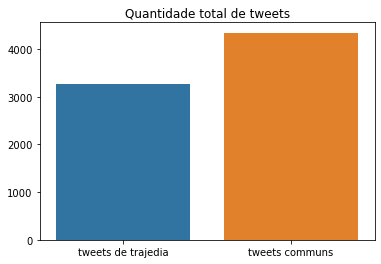

In [5]:
sns.barplot(
    ['tweets de trajedia', 'tweets communs'],
    [len(train_df[train_df.target == 1]),
     len(train_df[train_df.target == 0])])
plt.title('Quantidade total de tweets')

Text(0.5, 1.0, 'numero de caracteres em um tweet')

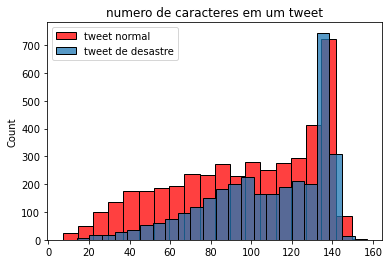

In [6]:
sizes_0 = [
    len(train_df[train_df.target == 0].text.iloc[i])
    for i in range(len(train_df[train_df.target == 0]))
]
sizes_1 = [
    len(train_df[train_df.target == 1].text.iloc[i])
    for i in range(len(train_df[train_df.target == 1]))
]

sns.histplot(sizes_0, label='tweet normal', color='red')
sns.histplot(sizes_1, label='tweet de desastre')
plt.legend()
plt.title('numero de caracteres em um tweet')

Text(0.5, 1.0, 'numero de palavras em um tweet')

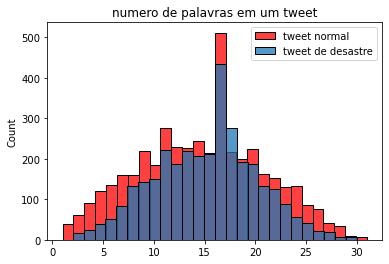

In [7]:
words_0 = [
    len(train_df[train_df.target == 0].text.iloc[i].split())
    for i in range(len(train_df[train_df.target == 0]))
]
words_1 = [
    len(train_df[train_df.target == 1].text.iloc[i].split())
    for i in range(len(train_df[train_df.target == 1]))
]

sns.histplot(words_0, label='tweet normal', color='red')
sns.histplot(words_1, label='tweet de desastre')
plt.legend()
plt.title('numero de palavras em um tweet')

Vemos aqui que os tweets comuns e os tweets de desastre tem uma estrutura muito parecida, com um numero de caracteres e um numero de palavras muito proximo. Isso nos diz que precisaremos analisar as palavras em sí.

### Vetorização do texto

Vamos agora tratar os dados dos tweets. Primeiro realizamos um processo de padronização, em que botamos todas as letras em minusculas e excluimos números, simbolos e afins. Depois, nos removemos as chamadas stop words, que são os artigos, preposições, verbos como ser e estar e outras palavras que não trazem nenhum tipo de valor sobre o conteudo desses tweets. Por fim reduzimos algumas palavras ao seu radical, para que o algoritmo entenda melhor e consiga processar as palavras dos tweets.

In [8]:
#importaçao da ntlk

from nltk.tokenize import word_tokenize
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\netoc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\netoc\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [9]:
#função que limpa o texto
def clean_text(text):
    stemmer = PorterStemmer()

    text_l = text.lower()
    text_l_nn = re.sub(r'\d+', '', text_l)
    text_l_nn_np = text_l_nn.translate(
        str.maketrans('', '', string.punctuation)).strip()
    stop_words = set(stopwords.words('english'))
    stop_words.add('û')
    stop_words.add('u')
    stop_words.add('im')
    stop_words.add('amp')
    tokens = word_tokenize(text_l_nn_np)
    result = " ".join([stemmer.stem(i) for i in tokens if not i in stop_words])
    return result

Essa função que limpa o texto tem uma serie de palavras adicionadas arbitrariamente as stop words. Essas palavras são as que são muito comuns tanto em um tipo de twwet quanto em outro, o que pode causar confusão em nosso algoritmo e portanto optamos por remove-las. 

In [10]:
#text=train_df['location']
#keyword=train_df.keyword.fillna('')
#bigstring=text+' '+keyword
train_df['text_processed'] = train_df['text'].map(lambda x: clean_text(x)) 

In [11]:
train_df[train_df.target==1].head()

,id,keyword,location,text,target,text_processed
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,deed reason earthquak may allah forgiv us
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la rong sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,resid ask shelter place notifi offic evacu she...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,peopl receiv wildfir evacu order california
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,got sent photo rubi alaska smoke wildfir pour ...


In [12]:
train_df[train_df.target==0].head()

,id,keyword,location,text,target,text_processed
15,23,NaN,NaN,What's up man?,0,what man
16,24,NaN,NaN,I love fruits,0,love fruit
17,25,NaN,NaN,Summer is lovely,0,summer love
18,26,NaN,NaN,My car is so fast,0,car fast
19,28,NaN,NaN,What a goooooooaaaaaal!!!!!!,0,goooooooaaaaaal


Vamos dar uma olhada agora em como são as palavras mais frequêntes agora que olhada texto foi processado

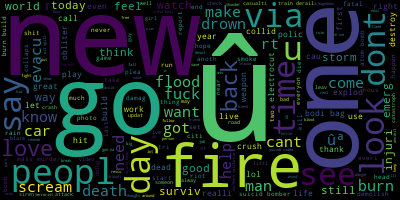

In [13]:
import wordcloud
# Join the different processed titles together.
long_string = ' '.join(train_df.text_processed)

# Create a WordCloud object
wordcloud_obj = wordcloud.WordCloud()

# Generate a word cloud
wordcloud_obj.generate(long_string)
# Visualize the word cloud
wordcloud_obj.to_image()


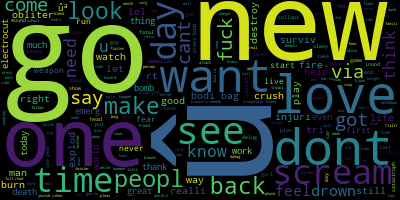

In [14]:
wordcloud_obj = wordcloud.WordCloud()

wordcloud_obj.generate(' '.join(train_df[train_df.target==0].text_processed))

wordcloud_obj.to_image()


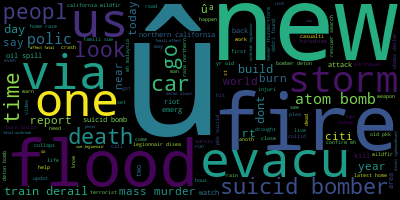

In [15]:
wordcloud_obj = wordcloud.WordCloud()

wordcloud_obj.generate(' '.join(train_df[train_df.target==1].text_processed))

wordcloud_obj.to_image()

Vemos por esses dois graficos que não existem palavras em destaque em comum nos dois tipos de tweets, isso acontece porque a medida que testavamos esse codigo fomos encontrando essas palavras e removendo-as manualmente ao adiciona-las as stop words. O "û" é provavelmente um bug do wordcloud pois eliminamis qualquer "û" dos dados.

### Classificação  usando clf e tdif

Agora vamos treinar modelos de aprendizado de maquina usando esses dados. Nesse caso precisamos transformar o texto em vetores booleanos que indicam se uma palavra está ou não no  texto.

In [16]:
#importar bibliotecas do sklearn
from sklearn import feature_extraction, linear_model, model_selection, preprocessing

In [17]:
#usando count vectorizer

count_vectorizer = feature_extraction.text.CountVectorizer()
train_vectors = count_vectorizer.fit_transform(train_df["text_processed"])
clf = linear_model.RidgeClassifier()
scores = model_selection.cross_val_score(clf, train_vectors, train_df["target"], cv=4, scoring="f1")
scores.mean()

0.5643766636623512

In [18]:
#usando tfidf ectorizer

from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer()

train_vectors = tfidf_vectorizer.fit_transform(train_df["text_processed"])
clf = linear_model.RidgeClassifier()

scores = model_selection.cross_val_score(clf, train_vectors, train_df["target"], cv=4, scoring="f1")
scores.mean()

0.6042258094960719

Obtivemos cerca de 60% de precisão nesses modelos, o que não é muito mas também não está ruim.

### Classificação usando keras e Tensorflow

Vamos agora tentar treinar um modelo através da biblioteca keras, que usa modelos de deeplearning através de camadas. De inicio vamos tentar usar apenas 2 camadas densas simples.

In [35]:
#importar bibliotecas keras
# baseado em https://realpython.com/python-keras-text-classification/#convolutional-neural-networks-cnn
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.layers import LSTM
from keras import layers
from keras.layers.embeddings import Embedding
from keras.backend import clear_session
from keras.preprocessing import sequence

In [36]:
#separação entre teste e treino
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences

X_train,  X_test,y_train, y_test=train_test_split(train_vectors.toarray(), train_df["target"],test_size=0.2)



In [37]:
model = Sequential()


model.add(Dense(15, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 15)                276810    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 16        
Total params: 276,826
Trainable params: 276,826
Non-trainable params: 0
_________________________________________________________________


In [38]:
#teste do modelo
history = model.fit(X_train, y_train,
                    epochs=2,
                    verbose=False, 
                    validation_data=(X_test, y_test),
                   batch_size=15)

In [39]:
#avaliação dos resultados
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.9236
Testing Accuracy:  0.8063


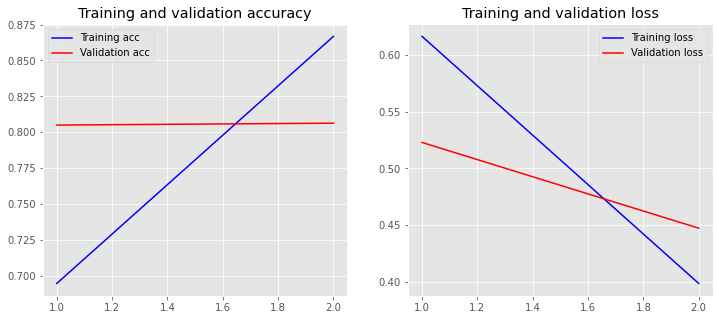

In [40]:
#ploting das epocas
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    
    
plot_history(history)

A precisão do algoritmo ja melhorou bastante e esta proxima de 77%

In [87]:
clear_session()

### Tokenização com Keras


 Vamos aplicar um segundo algoritmo comm keras, agora fazendo uma tokenização dos textos

In [72]:
from keras.preprocessing.text import Tokenizer

X_train, X_test, y_train, y_test = train_test_split(train_df['text_processed'],
                                                    train_df["target"],
                                                    test_size=0.2)

tokenizer = Tokenizer(num_words=180000)
tokenizer.fit_on_texts(X_train)

X_train_t = tokenizer.texts_to_sequences(X_train)
X_test_t = tokenizer.texts_to_sequences(X_test)

vocab_size = len(
    tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index



In [73]:
from keras.preprocessing.sequence import pad_sequences

maxlen = 250

X_train_t = pad_sequences(X_train_t, padding='post', maxlen=maxlen)
X_test_t = pad_sequences(X_test_t, padding='post', maxlen=maxlen)

In [74]:
from keras.models import Sequential
from keras import layers

embedding_dim = 50

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
model.add(layers.Flatten())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 250, 50)           796100    
_________________________________________________________________
flatten (Flatten)            (None, 12500)             0         
_________________________________________________________________
dense (Dense)                (None, 10)                125010    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 921,121
Trainable params: 921,121
Non-trainable params: 0
_________________________________________________________________


Training Accuracy: 0.5670
Testing Accuracy:  0.5837


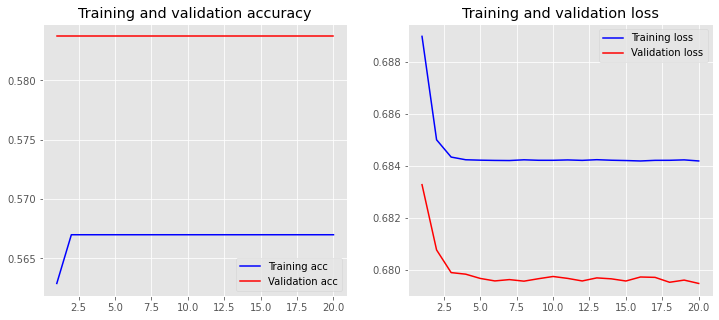

In [75]:
history = model.fit(X_train_t, y_train,
                    epochs=20,
                    verbose=False,
                    validation_data=(X_test_t, y_test),
                    batch_size=10)
loss, accuracy = model.evaluate(X_train_t, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test_t, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

In [76]:
clear_session()

Um segundo modelo  fazendo pequenas alterações

In [77]:
from keras.models import Sequential
from keras import layers

embedding_dim = 50

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 250, 50)           796100    
_________________________________________________________________
global_max_pooling1d (Global (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 10)                510       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 796,621
Trainable params: 796,621
Non-trainable params: 0
_________________________________________________________________


Training Accuracy: 0.9951
Testing Accuracy:  0.7761


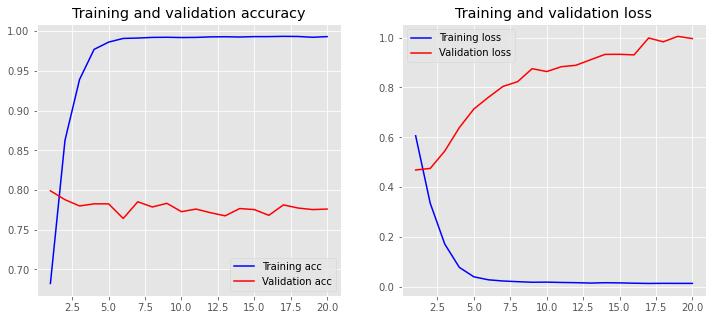

In [78]:
history = model.fit(X_train_t, y_train,
                    epochs=20,
                    verbose=False,
                    validation_data=(X_test_t, y_test),
                    batch_size=10)
loss, accuracy = model.evaluate(X_train_t, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test_t, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

In [80]:
clear_session()

### Submissão de arquivo para o Kaggle

O primeiro modelo  de keras que fizemos foi o com maior precisão, e por isso vamos utiliza-lo para predizer os dados do segundo dataset e submeter nosso resultado para a competição do kaggle.

In [41]:
test_df = pd.read_csv("test.csv")
sample_submission = pd.read_csv("sample_submission.csv")

In [42]:
test_df['text_processed'] = test_df['text'].map(lambda x: clean_text(x))
test_vectors = tfidf_vectorizer.transform(test_df["text_processed"])

In [43]:
preds=np.rint(model.predict(test_vectors.toarray())).astype('int64')
preds.astype('int64')
sample_submission["target"] = [i[0] for i in preds]

In [44]:
sample_submission.target.mean()

0.37296965982224944

In [45]:
sample_submission.drop(['Unnamed: 0'], inplace=True, axis=1)


KeyError: "['Unnamed: 0'] not found in axis"

In [46]:
sample_submission.to_csv("sample_submission.csv", index=False)

In [47]:
sample_submission = pd.read_csv("sample_submission.csv")
sample_submission.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


Obtivemos com esse codigo uma precisãomaxima de 0.79374